In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/reservation-cancellation-prediction/train__dataset.csv
/kaggle/input/reservation-cancellation-prediction/test___dataset.csv
/kaggle/input/playground-series-s3e7/sample_submission.csv
/kaggle/input/playground-series-s3e7/train.csv
/kaggle/input/playground-series-s3e7/test.csv


In [2]:
import math
import itertools
from operator import itemgetter

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from sklearn.base import BaseEstimator
from sklearn.model_selection import KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing  import OneHotEncoder, MinMaxScaler, StandardScaler, FunctionTransformer

seed = -3241747941808157888 & 0xffffffff #hash of my username

pd.set_option('display.max_columns', 100)

url = "/kaggle/input/playground-series-s3e7/"
url_extra = "/kaggle/input/reservation-cancellation-prediction/"

In [3]:
df_train = pd.read_csv(url + 'train.csv', index_col=0)
df_test = pd.read_csv(url + 'test.csv', index_col=0)
df_extra = pd.read_csv(url_extra + 'train__dataset.csv')

unknown_features = [f"V{i}" for i in range(1, 29)]

x_cols = [col for col in df_train.columns if col not in {'booking_status'}]
y_col = 'booking_status'

x_cols_ord = [col for col in x_cols if df_train[col].nunique() < 30]
x_cols_num = [col for col in x_cols if col not in x_cols_ord]

df_train.sample(5)

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
id,,,,,,,,,,,,,,,,,,
23354,1,0,1,2,0,0,0,164,2018,10,16,0,0,0,0,115.0,0,1
25131,2,2,0,1,0,0,3,17,2018,10,7,1,0,0,0,224.1,2,0
15088,1,0,0,4,2,0,0,296,2018,9,21,0,0,0,0,85.0,0,0
21256,2,0,0,3,1,0,0,132,2018,7,5,1,0,0,0,103.5,0,1
40776,2,0,1,0,0,0,0,258,2018,10,15,0,0,0,0,110.0,0,1


In [4]:
df_train.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 42100 entries, 0 to 42099
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   no_of_adults                          42100 non-null  int64  
 1   no_of_children                        42100 non-null  int64  
 2   no_of_weekend_nights                  42100 non-null  int64  
 3   no_of_week_nights                     42100 non-null  int64  
 4   type_of_meal_plan                     42100 non-null  int64  
 5   required_car_parking_space            42100 non-null  int64  
 6   room_type_reserved                    42100 non-null  int64  
 7   lead_time                             42100 non-null  int64  
 8   arrival_year                          42100 non-null  int64  
 9   arrival_month                         42100 non-null  int64  
 10  arrival_date                          42100 non-null  int64  
 11  market_segment_

In [5]:
df_train[df_train.duplicated(x_cols, keep=False)].sort_values(x_cols)


,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
id,,,,,,,,,,,,,,,,,,
32634,1,0,0,1,0,0,0,1,2018,2,28,0,0,0,0,60.00,0,1
34909,1,0,0,1,0,0,0,1,2018,2,28,0,0,0,0,60.00,0,0
12933,1,0,0,1,0,0,0,8,2018,11,5,0,0,0,0,120.00,0,0
40241,1,0,0,1,0,0,0,8,2018,11,5,0,0,0,0,120.00,0,1
36058,1,0,0,1,0,0,0,45,2018,1,23,1,0,0,0,72.90,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12937,3,0,1,3,0,0,1,184,2018,10,17,1,0,0,0,128.70,2,1
4935,3,0,2,2,0,0,1,68,2018,7,24,1,0,0,0,137.70,1,1
12767,3,0,2,2,0,0,1,68,2018,7,24,1,0,0,0,137.70,1,0


In [6]:
df_train = df_train.sort_values(y_col).drop_duplicates(x_cols, keep='last')
df_extra = df_extra.sort_values(y_col).drop_duplicates(x_cols, keep='last')

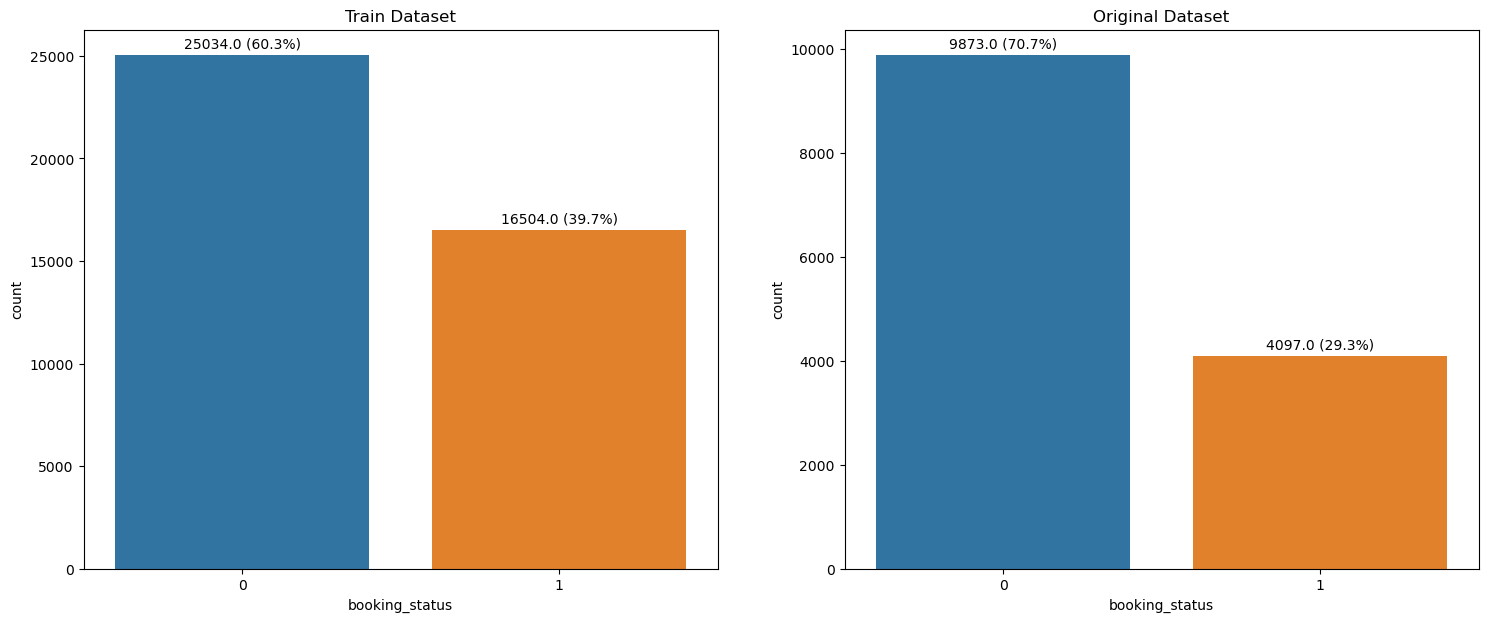

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

data = {
    'Train Dataset': df_train[y_col],
    'Original Dataset': df_extra[y_col],
}

for (name, x), ax in zip(data.items(), axes):
    sns.countplot(x=x, ax=ax)
    ax.set_title(name)

    labels_pct = [
        f"{l} ({l/sum(ax.containers[0].datavalues):.1%})"
        for l
        in ax.containers[0].datavalues
    ]

    ax.bar_label(ax.containers[0],
                 labels=labels_pct,
                 padding=3);

In [8]:
df_train[x_cols].describe(percentiles=[.01, .05, .25, .50, .75, .95, .99])

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
count,41538.000000,41538.000000,41538.000000,41538.000000,41538.000000,41538.000000,41538.000000,41538.000000,41538.000000,41538.000000,41538.000000,41538.000000,41538.000000,41538.000000,41538.000000,41538.000000,41538.000000
mean,1.921879,0.142833,0.886730,2.401632,0.236723,0.025567,0.433747,103.180533,2017.856806,7.594708,15.912056,0.733232,0.029587,0.019982,0.178150,104.690837,0.576099
std,0.526256,0.452676,0.886458,1.431460,0.584018,0.157841,0.836117,80.662442,0.350275,2.831081,8.892011,0.633713,0.169448,0.328026,1.743678,37.276755,0.777354
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5%,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000,2017.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,60.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,37.000000,2018.000000,6.000000,8.000000,0.000000,0.000000,0.000000,0.000000,80.000000,0.000000
50%,2.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,92.000000,2018.000000,8.000000,16.000000,1.000000,0.000000,0.000000,0.000000,99.450000,0.000000
75%,2.000000,0.000000,2.000000,3.000000,0.000000,0.000000,1.000000,154.000000,2018.000000,10.000000,24.000000,1.000000,0.000000,0.000000,0.000000,123.300000,1.000000
95%,3.000000,1.000000,2.000000,5.000000,2.000000,0.000000,2.000000,259.000000,2018.000000,12.000000,30.000000,1.000000,0.000000,0.000000,0.000000,169.532000,2.000000


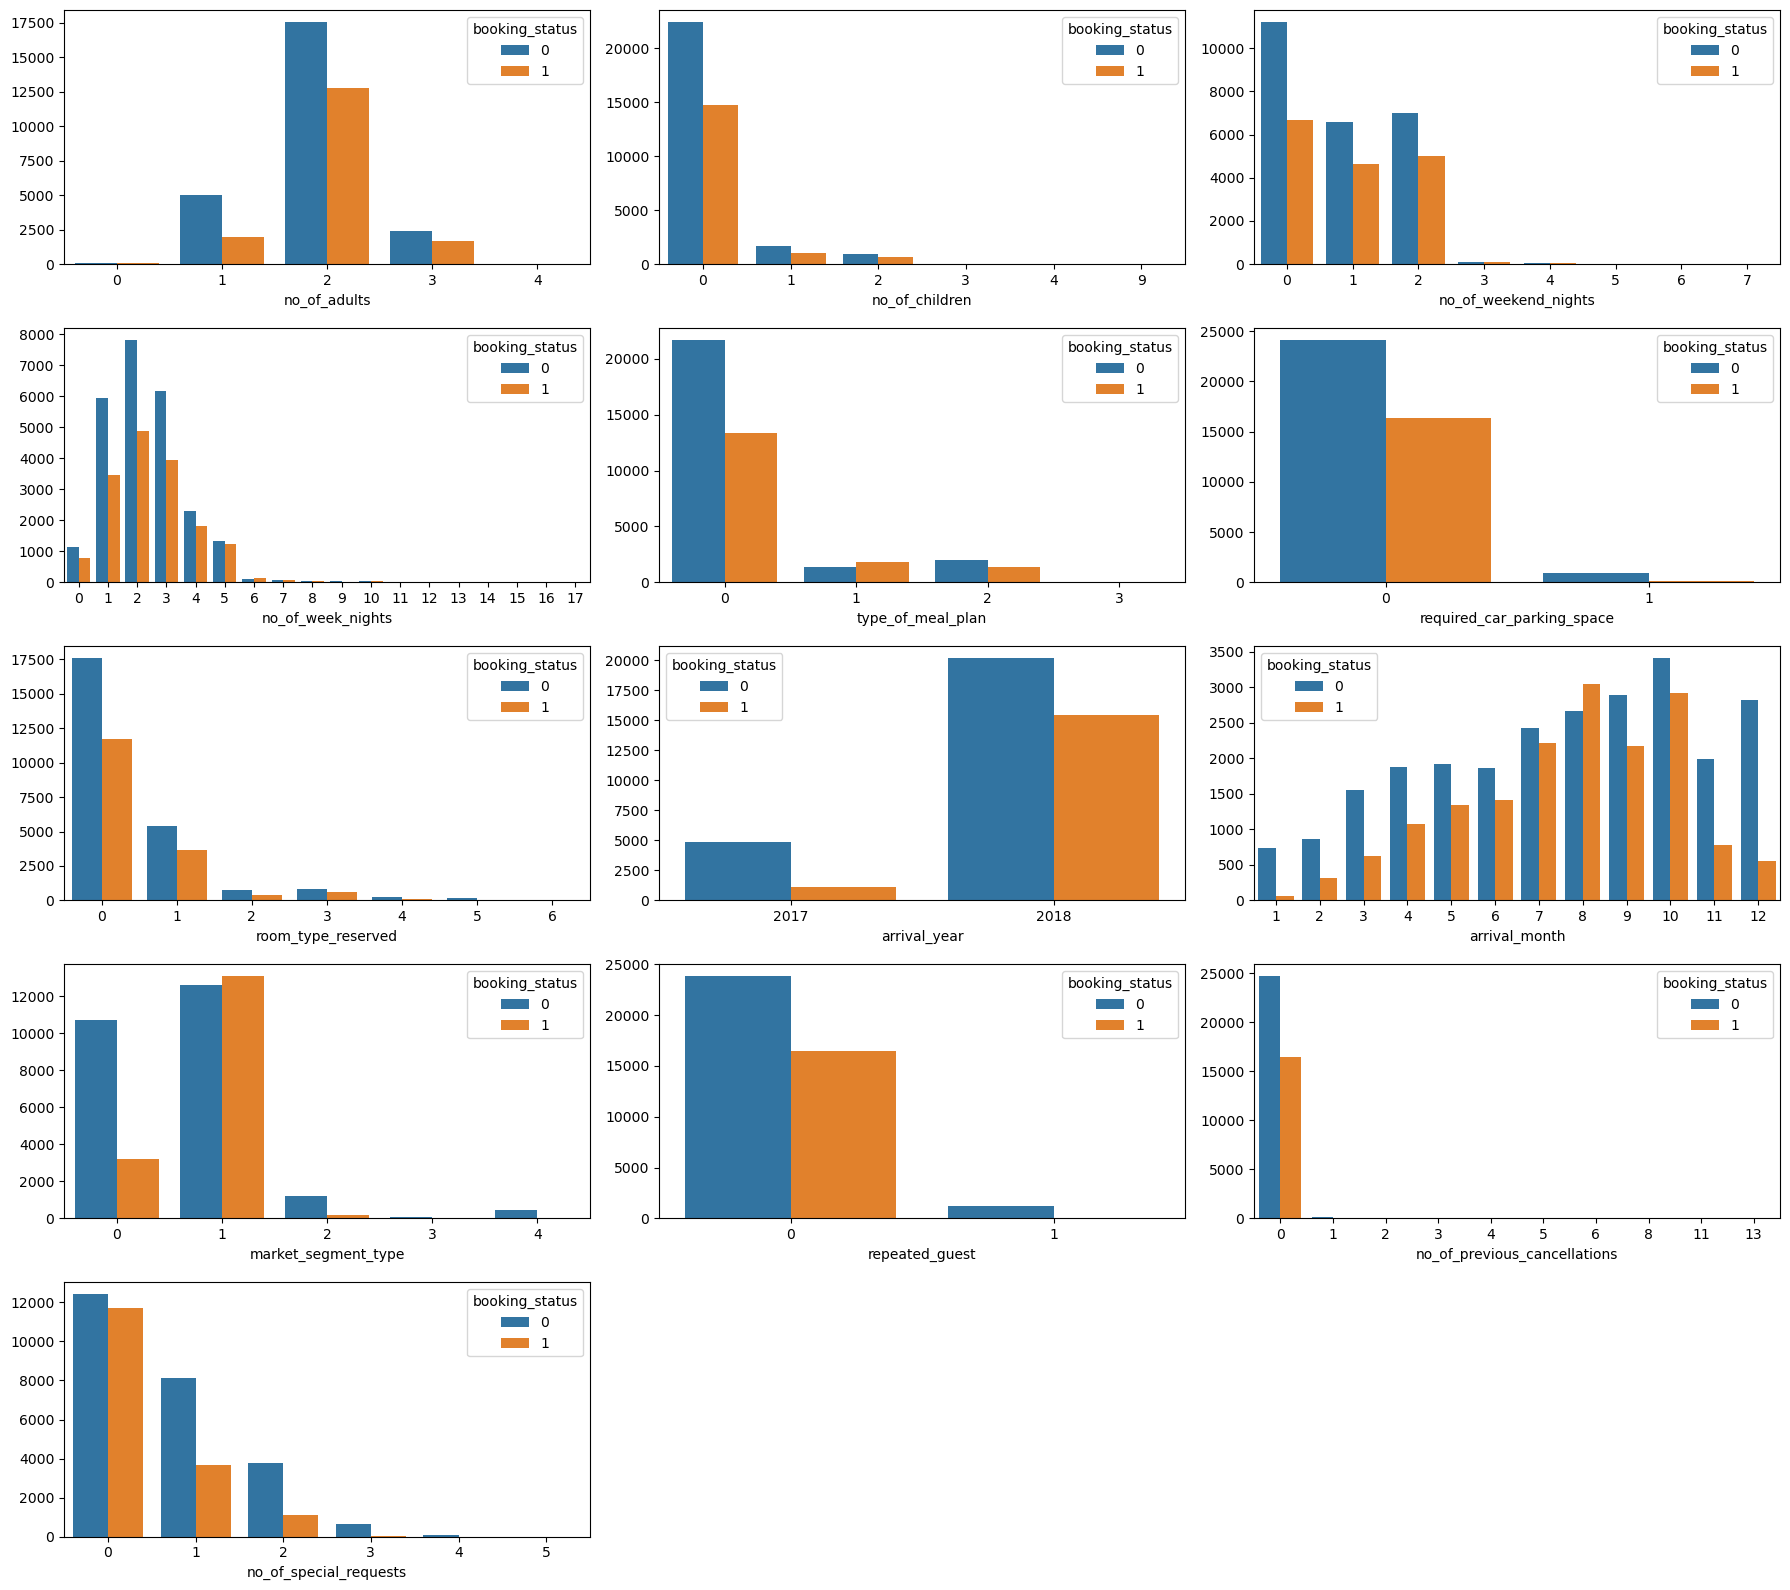

In [9]:
rows, cols = math.ceil(len(x_cols_ord) / 3), 3
fig, axes = plt.subplots(rows, cols, figsize=(18, 16))

for col, ax in zip(x_cols_ord, axes.flatten()):
    sns.countplot(x=df_train[col],
                  hue=df_train[y_col],
                  ax=ax)

    ax.set_ylabel('')

for ax in axes.flatten():
    if not ax.get_xlabel():
        ax.set_visible(False)

plt.tight_layout()

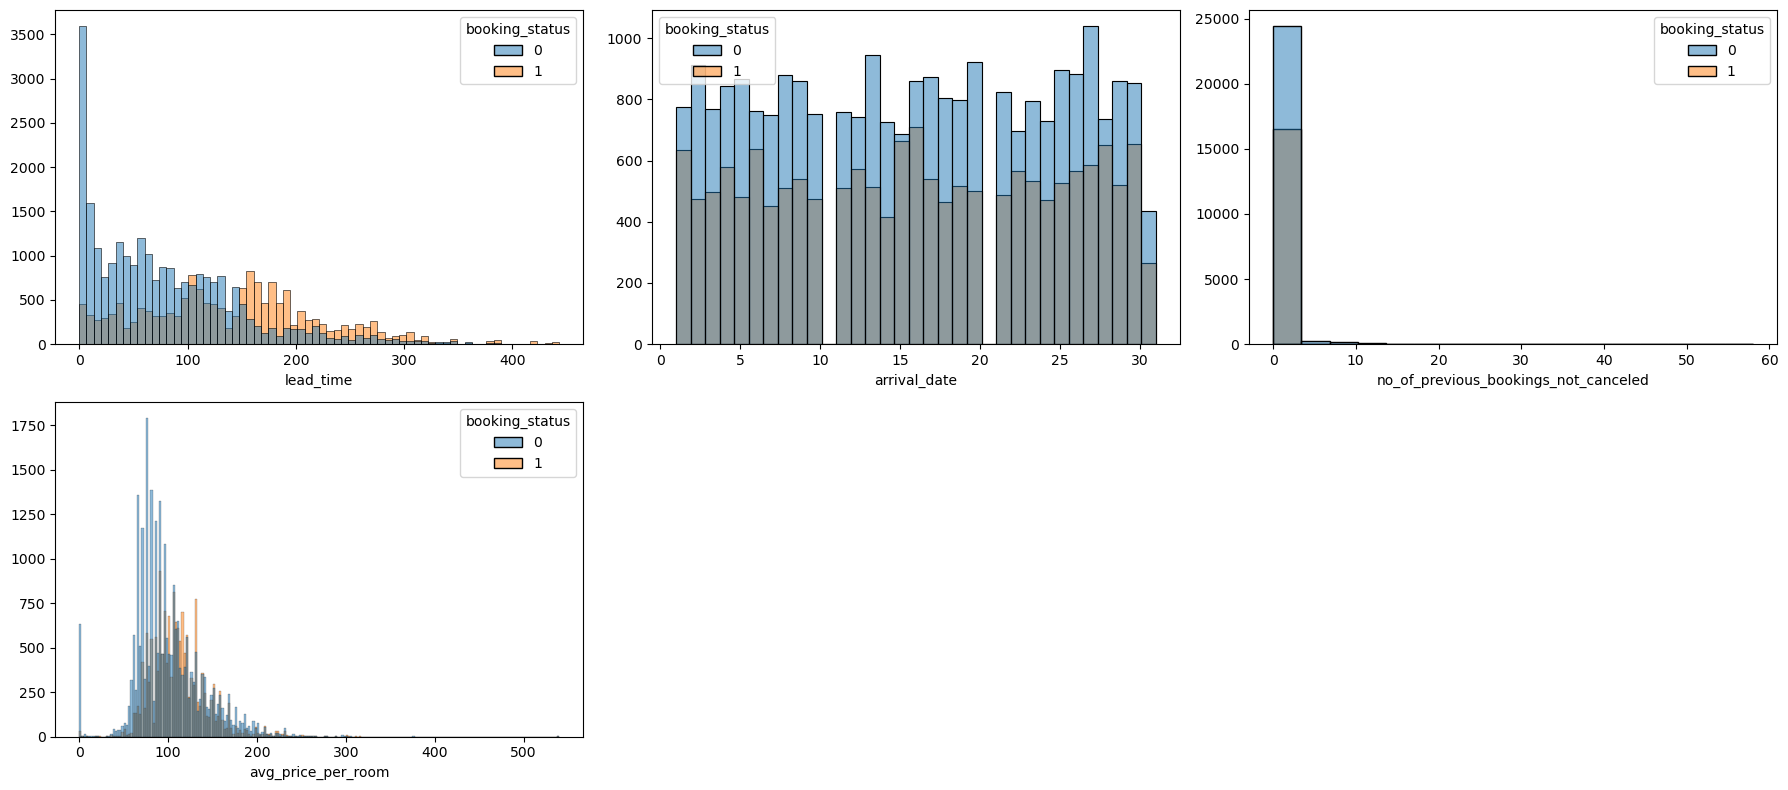

In [10]:
rows, cols = math.ceil(len(x_cols_num) / 3), 3
fig, axes = plt.subplots(rows, cols, figsize=(18, 8))

for col, ax in zip(x_cols_num, axes.flatten()):
    sns.histplot(x=df_train[col],
                 hue=df_train[y_col],
                 ax=ax)

    ax.set_ylabel('')

for ax in axes.flatten():
    if not ax.get_xlabel():
        ax.set_visible(False)

plt.tight_layout()

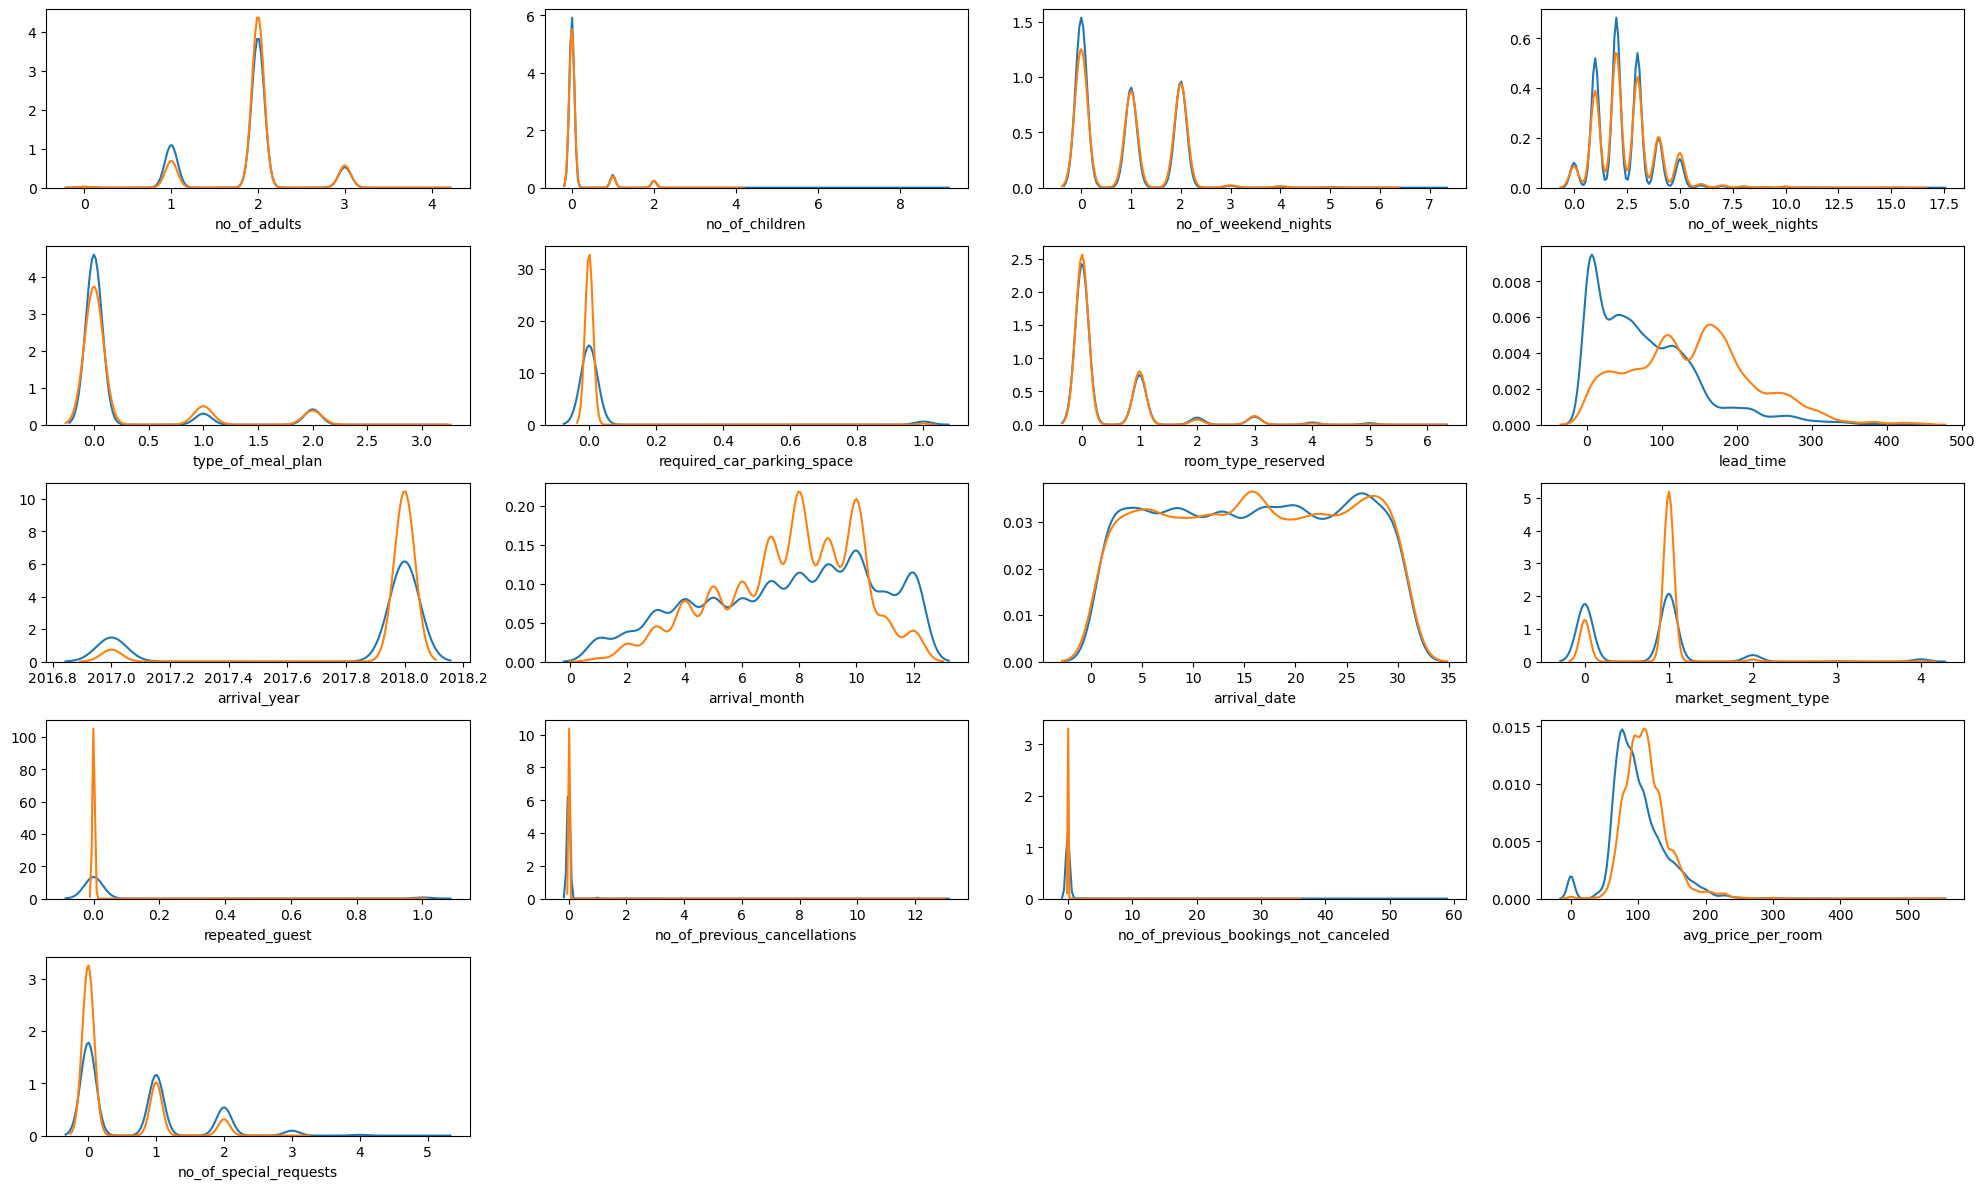

In [11]:
rows, cols = math.ceil(len(x_cols) / 4), 4
fig, axes = plt.subplots(rows, cols, figsize=(20, 12))

for col, ax in zip(x_cols, axes.flatten()):
    sns.kdeplot(x=df_train[df_train[y_col] == 0][col],
                ax=ax)

    sns.kdeplot(x=df_train[df_train[y_col] == 1][col],
                ax=ax)

    ax.set_ylabel('')

for ax in axes.flatten():
    if not ax.get_xlabel():
        ax.set_visible(False)

plt.tight_layout()

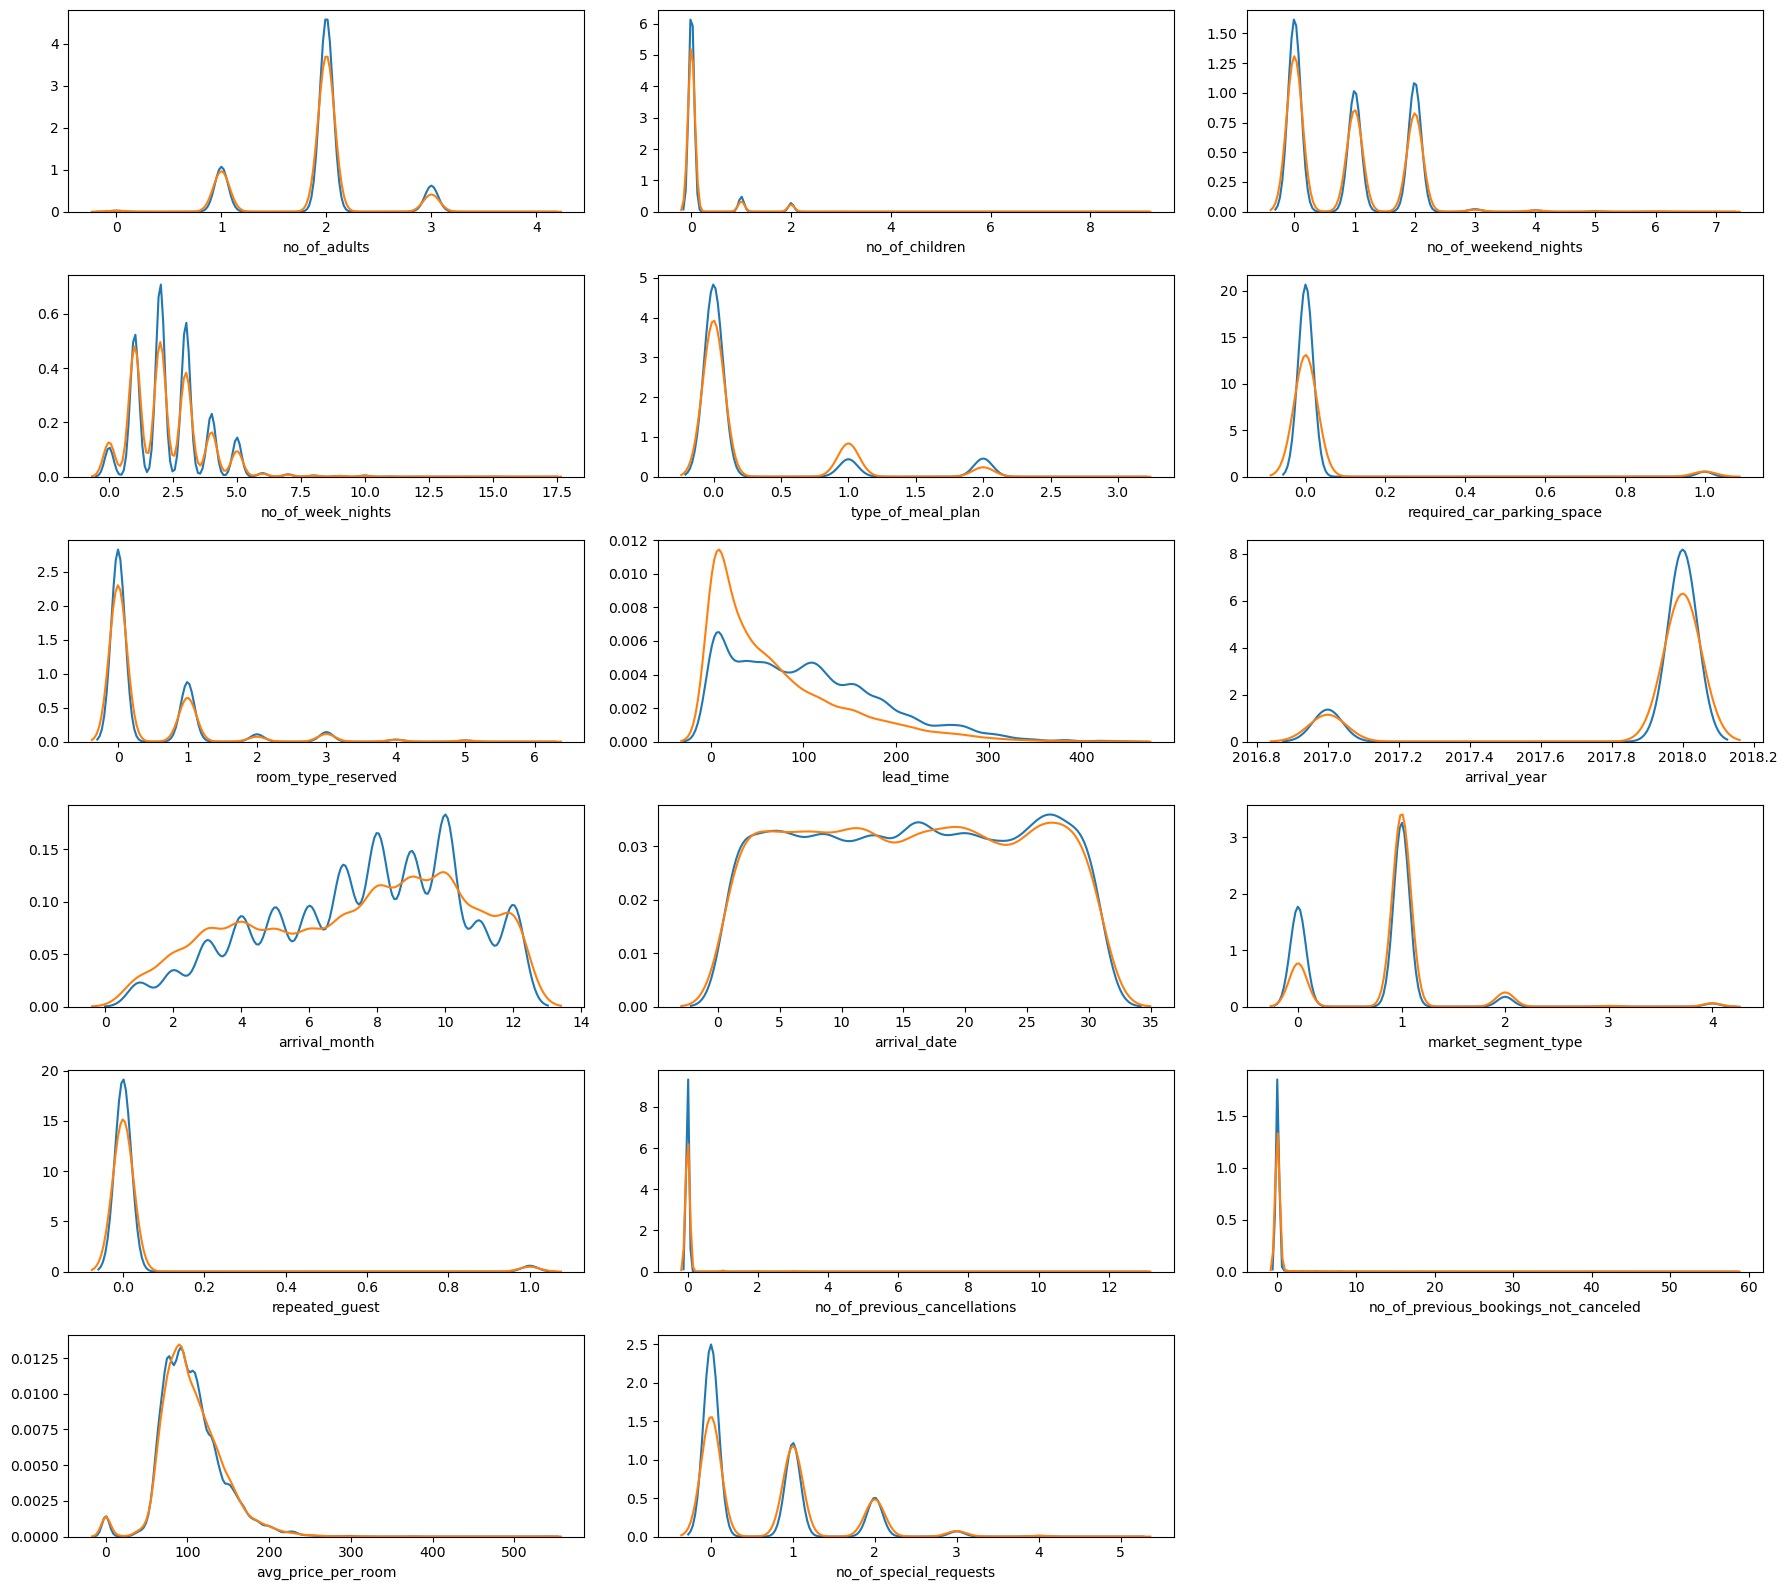

In [12]:
rows, cols = math.ceil(len(x_cols) / 3), 3
fig, axes = plt.subplots(rows, cols, figsize=(18, 16))

for col, ax in zip(x_cols, axes.flatten()):
    sns.kdeplot(x=df_train[col],
                ax=ax)

    sns.kdeplot(x=df_extra[col],
                ax=ax)

    ax.set_ylabel('')

for ax in axes.flatten():
    if not ax.get_xlabel():
        ax.set_visible(False)

plt.tight_layout()

In [13]:
from sklearn.metrics import roc_auc_score, RocCurveDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from lightgbm.sklearn import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.ensemble import VotingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

In [14]:
class RocCurve:
    def __init__(self):
        self.score = []
        self.y = []
        self.y_pred = []
        

    def add_prediction(self, y, y_pred):
        self.score.append(roc_auc_score(y, y_pred))
        self.y.append(y)
        self.y_pred.append(y_pred)


    def plot_roc(self):
        RocCurveDisplay.from_predictions(y_true=np.hstack(self.y),
                                         y_pred=np.hstack(self.y_pred))
        plt.xlabel('FP Rate')
        plt.ylabel('TP Rate')


    def get_roc_auc(self):
        return np.mean(self.score)


    def __str__(self):
        return f"ROC AUC: {self.get_roc_auc():.4f}"

In [15]:
def roc_stratified_kfold(model, X, y, X_extra=None, y_extra=None, verbose=True):
    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    roc_curve = RocCurve()

    for idx_train, idx_val in folds.split(X, y):
        # Split the DataFrame into `train` and `val`
        X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        X_val, y_val = X.iloc[idx_val], y.iloc[idx_val]

        if X_extra is not None and y_extra is not None:
            X_train = X_train.append(X_extra, ignore_index=True)
            y_train = y_train.append(y_extra, ignore_index=True)

        # Fit the model
        model.fit(X_train, y_train)

        # Save the result to the RocCurve object
        roc_curve.add_prediction(y_val, model.predict_proba(X_val)[:, 1])

    # Plot the result
    if verbose:
        print(roc_curve)
        roc_curve.plot_roc()
    
    return roc_curve.get_roc_auc()

In [16]:
def roc_search_cv(model, X, y, param_distributions, n_iter=50):
    search_cv = RandomizedSearchCV(estimator=model,
                                   scoring='roc_auc',
                                   n_iter=n_iter,
                                   cv=5,
                                   n_jobs=-1,
                                   param_distributions=param_distributions,
                                   random_state=seed)

    search_cv.fit(X, y)

    # Update the model params to the best combination found
    model.set_params(**search_cv.best_params_)

    # Prints the best parameters found
    print(search_cv.best_params_)

    # Run CV and plot the ROC curve.
    roc_stratified_kfold(model=model, X=X, y=y)
    
    return model

In [17]:
def make_classifier_pipeline(model):
    return Pipeline([
#         ('column_transformer', column_transformer),
        ('scaler', MinMaxScaler()),
        ('model', model)
    ])

In [18]:
models = {}

ROC AUC: 0.8374
CPU times: user 8.02 s, sys: 5.19 s, total: 13.2 s
Wall time: 3.39 s


0.8374343018176358

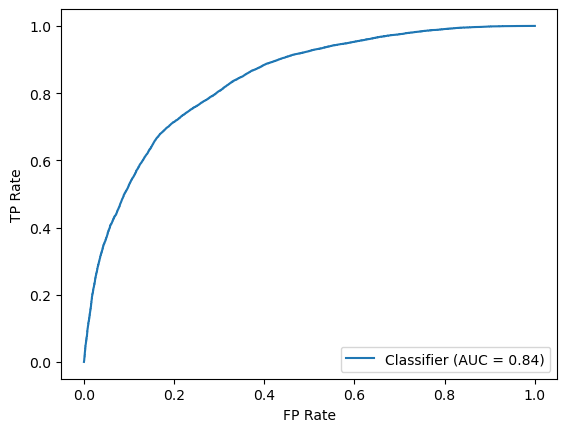

In [19]:
%%time

models['logistic_regression'] = make_classifier_pipeline(
    LogisticRegression(random_state=seed)
)

roc_stratified_kfold(model=models['logistic_regression'],
                     X=df_train[x_cols],
                     y=df_train[y_col],
                     X_extra=df_extra[x_cols],
                     y_extra=df_extra[y_col])

ROC AUC: 0.8984
CPU times: user 4min 53s, sys: 573 ms, total: 4min 54s
Wall time: 4min 54s


0.898410343991219

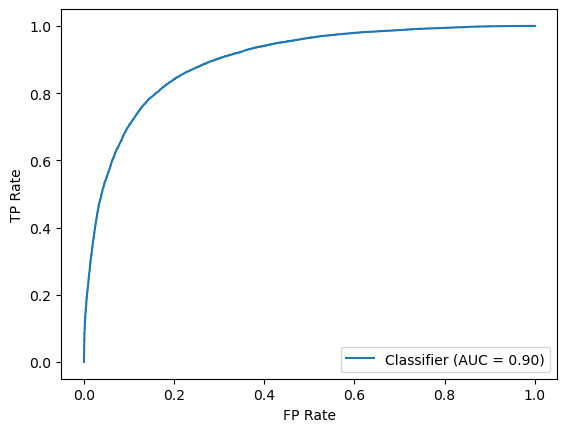

In [20]:
%%time

models['random_forest'] = make_classifier_pipeline(
    RandomForestClassifier(random_state=seed, max_depth=16, n_estimators=950)
)

roc_stratified_kfold(model=models['random_forest'],
                     X=df_train[x_cols],
                     y=df_train[y_col],
                     X_extra=df_extra[x_cols],
                     y_extra=df_extra[y_col])

In [21]:
from numpy import nan


ROC AUC: 0.9036
CPU times: user 1min 4s, sys: 267 ms, total: 1min 5s
Wall time: 16.9 s


0.903614322109647

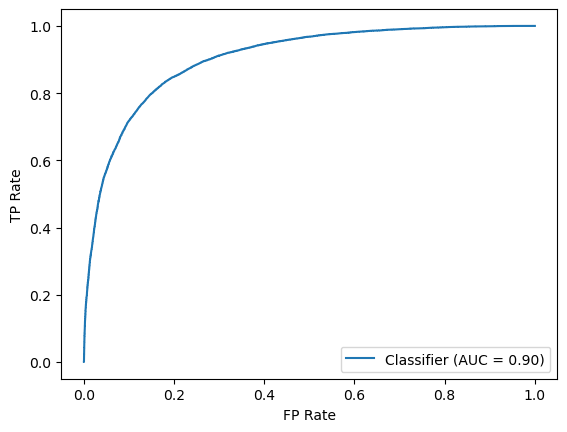

In [22]:
%%time

models['xgb'] = make_classifier_pipeline(
    XGBClassifier(random_state=seed, base_score=0.5, booster='gbtree', callbacks=None,
               colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
               importance_type=None, interaction_constraints='',
               learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
               max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
               missing=nan, monotone_constraints='()', n_estimators=100,
               n_jobs=-1, num_parallel_tree=1, objective='binary:logistic',
               predictor='auto', reg_alpha=0,)
)

roc_stratified_kfold(model=models['xgb'],
                     X=df_train[x_cols],
                     y=df_train[y_col],
                     X_extra=df_extra[x_cols],
                     y_extra=df_extra[y_col])

ROC AUC: 0.8988
CPU times: user 9.71 s, sys: 2.83 s, total: 12.5 s
Wall time: 7.46 s


0.8988490288280637

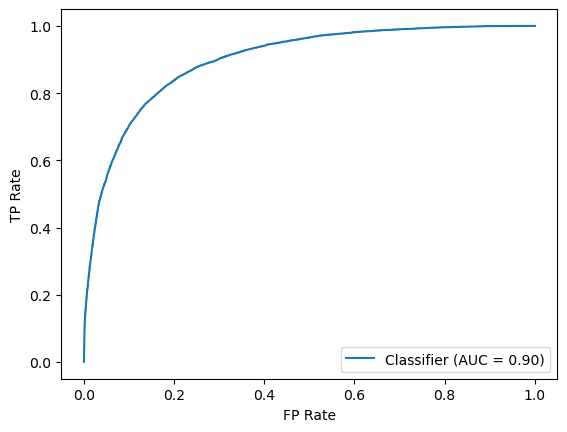

In [23]:
%%time

models['lgbm'] = make_classifier_pipeline(
    LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                importance_type='split', learning_rate=0.1, max_depth=-1,
                min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
                n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
                random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
                subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
)

roc_stratified_kfold(model=models['lgbm'],
                     X=df_train[x_cols],
                     y=df_train[y_col],
                     X_extra=df_extra[x_cols],
                     y_extra=df_extra[y_col])

ROC AUC: 0.9031
CPU times: user 44.4 s, sys: 2.85 s, total: 47.3 s
Wall time: 42 s


0.9030937524610095

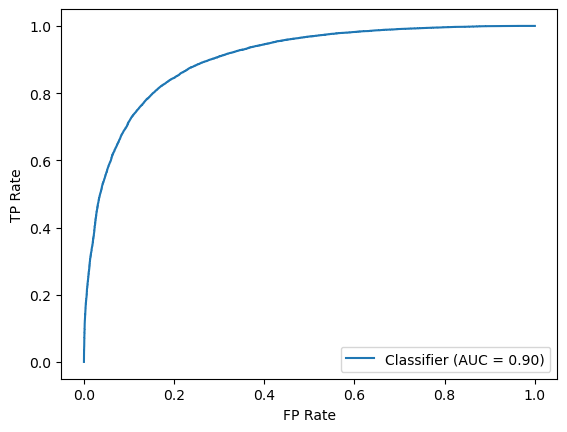

In [24]:
%%time

models['ensemble'] = make_classifier_pipeline(
    VotingClassifier([
        ('xgb', models['xgb']['model']),
        ('lgbm', models['lgbm']['model']),
    ], voting='soft')
)

roc_stratified_kfold(model=models['ensemble'],
                     X=df_train[x_cols],
                     y=df_train[y_col],
                     X_extra=df_extra[x_cols],
                     y_extra=df_extra[y_col])

In [25]:
df_full = df_train.append(df_extra)

model = models['ensemble'].fit(df_full[x_cols], df_full[y_col])
df_test[y_col] = model.predict_proba(df_test[x_cols])[:, 1]

df_test[[y_col]].to_csv('submission.csv')
df_test[[y_col]]

,booking_status
id,
42100,0.239120
42101,0.054297
42102,0.388534
42103,0.049546
42104,0.366896
...,...
70163,0.971732
70164,0.041626
70165,0.093398
